In [6]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.providers import JobStatus
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram
from math import atan2, sqrt, pi
import import_ipynb
import numpy as np
import math
#import probabilities as prob

In [2]:
#statesStayHome, statesTests, statesCases = prob.get_lesser_model_states()
#basic_graph = prob.get_conditional_probability(statesStayHome, statesTests, statesCases)[2]

"""
Order of Cases conditional probabilities in graph: 
P(C=0|A=0,B=0), P(C=1|A=0,B=0), P(C=0|A=0,B=1), P(C=1|A=0,B=1), P(C=0|A=1,B=0), P(C=1|A=1,B=0), P(C=0|A=1,B=1), P(C=1|A=1,B=1)
From Fig 4 in https://arxiv.org/pdf/2004.14803.pdf -- 
our order is first col first row, first col second row, second col first row, etc. 
so the first two probabilities add up to one, the third and fourth add up to one, etc. 
"""
#print(basic_graph)
oil_graph = {'IR': ([], [.75, .25]), # From 2004.14803, Fig 10
         'SM': (['IR'], [.3, .7, .8, .2]), #P(0|!A), P(1|!A), P(0|A), P(1|A)
         'OI': ([], [.6, .4]),
         'SP': (['OI', 'SM'], [.9, .1, .5, .5, .4, .6, .2, .8])
        }


In [3]:
#TODO assertAlmostEqual(angle_from_probability(0.2, 0.8), 2.2143)
def angle_from_probability(p0, p1):
    # from 2004.14803 equation 20
    angle = 2 * atan2(sqrt(p1), sqrt(p0))
    return angle

In [7]:
def find_num_states(numprobs, in_edges):
    if in_edges == 0: # if parent node
        numstates = numprobs
    elif in_edges > 0: # if child node
        numstates = (numprobs/(2**(in_edges+1))) * 2
    return numstates

def find_numstates_parents(graph, parentvarnames):
    """Eqn 21 from https://arxiv.org/pdf/2004.14803.pdf"""
    numstates_parents = 0
    for i in range(len(parentvarnames)):
        parent = parentvarnames[i]
        parentprobs = graph[parent]
        numprobs = len(parentprobs[1]) # number of states if parent node, number of conditional states if child node
        in_edges = len(graph[parent][0]) # aka num of parents of this parent
        numstates_parents += find_num_states(numprobs, in_edges)
    return numstates_parents
    
    
def num_qbits_needed_general(graph): 
    sumterm = 0
    ancillaterms = []
    varnum = 0
    for var in graph:
        probs = graph[var]
        numprobs = len(probs[1]) # number of states if parent node, number of conditional states if child node
        in_edges = len(graph[var][0]) # aka num of parents
        numstates = find_num_states(numprobs, in_edges)
        sumterm += math.ceil(np.log2(numstates))
        if in_edges > 0:
            parentvarnames = graph[var][0] # list of parent names
            numstates_parents = find_numstates_parents(graph, parentvarnames)
            ancillaterm = numstates_parents/2 + math.ceil(np.log2(numstates)) - 1 
            ancillaterms.append(ancillaterm)
    qbits = sumterm + max(ancillaterms) -1 # equation (22) WITH AN EXTRA -1
    cbits = sumterm # number of measurements
    return (qbits, cbits)

"""
works for 3 node case now. 
graph = { 'StayAtHome': ([], [.3, .7]), # P(A = 0), P(A = 1)
                'Testing': ([], [.4, .6]),  #P(B = 0), P(B = 1)
                #P(C=0|A=0,B=0), P(C=1|A=0,B=0), P(C=0|A=0,B=1), P(C=1|A=0,B=1), P(C=0|A=1,B=0), P(C=1|A=1,B=0), P(C=0|A=1,B=1), P(C=1|A=1,B=1)
                'Cases': (['StayAtHome','Testing'], [.3, .7, .1, .9, .4, .6, .3, .7])
              }
print(num_qbits_needed_general(graph))"""

def num_qbits_needed(graph):
    max_edges = -1 
    for state in graph:
        in_edges = len(graph[state][0]) # aka num of parents
        if in_edges > max_edges:
            max_edges = in_edges
    
    qbits = len(graph) + max_edges - 1 # equation (15)
    cbits = len(graph) # number of measurements
    return (qbits, cbits)

(4.0, 3)


In [5]:
def run_circuit(circuit, output_file='results', draw_circuit=True, use_sim=True, use_noise=False, use_qcomp=False, shots=1024):
    if draw_circuit:
        #print(circuit.draw())
        %config InlineBackend.figure_format
        circuit.draw(output='mpl')

    if use_noise or use_qcomp:
        IBMQ.load_account()
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend('ibmq_16_melbourne')

    if use_sim:
        simulator = Aer.get_backend('qasm_simulator')
        if use_noise:
            noise_model = NoiseModel.from_backend(qcomp)
            basis_gates = noise_model.basis_gates
            coupling_map = qcomp.configuration().coupling_map
            job = execute(circuit, backend=simulator, coupling_map=coupling_map, noise_model=noise_model, basis_gates=basis_gates, shots=shots)
        else:
            job = execute(circuit, backend=simulator, shots=shots)
        print(job.result().get_counts())
        plot_histogram(job.result().get_counts()).savefig(output_file+"-sim.png")


    if use_qcomp:
        job = execute(circuit, backend=qcomp, shots=shots)
        job_monitor(job)
        if(job.status() == JobStatus.ERROR):
            print("Error: Check with IBMQ")
        print(job.result().get_counts())
        plot_histogram(job.result().get_counts()).savefig(output_file+'-qcomp.png')
    return job.result()

In [6]:
def add_cny(circuit, n, angle, control_bits, target, ancilla_bits):
    '''
    Creates generalized cny gate for any n.
    
    circuit:       existing circuit to modify
    n:             number of control bits required (number of "C"s wanted for this gate)
    angle:         angle to rotate by (rad)
    control_bits:  list (len n)
    target:        qbit you want to rotate
    ancilla_bits:  list (len n-1); these are left clean (in same state as initially)
    
    Note: could also try rewriting using Qiskit's built-in mcx gates
    https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.mcx.html
    https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html
    '''
    # assert some things are true
    assert n >= 2
    assert len(control_bits) == n
    assert len(ancilla_bits) == n-1
    
    circuit.barrier() # for visualization
    
    # hardcode first ccx gate
    circuit.ccx(control_bits[0], control_bits[1], ancilla_bits[0])
    
    # loop to create ccx gates
    for i in range(2, n):
        circuit.ccx(control_bits[i], ancilla_bits[i-2], ancilla_bits[i-1])
    
    # add rotate block
    circuit.cry(angle, ancilla_bits[n-2], target)
    
    # loop to create remaining ccx gates
    for i in range(n-1, 1, -1):
        circuit.ccx(control_bits[i], ancilla_bits[i-2], ancilla_bits[i-1])
        
    # hardcode last ccx gate
    circuit.ccx(control_bits[0], control_bits[1], ancilla_bits[0])
    
    circuit.barrier() # for visualization
    
    return circuit


In [34]:
def create_circuit(graph):
    
    # initialize circuit
    (qbits, cbits) = num_qbits_needed(graph)
    qc = QuantumCircuit(qbits, cbits)
    
    bit_assignment = {}
    ancilla_bits = []
    next_free_qbit = 0
    
    # loop and find the parentless nodes (sad orphans), assign their rotations first
    for node in graph:
        number_of_parents = len(graph[node][0])
        if number_of_parents == 0:            
            probs = graph[node][1]
            
            qc.ry(angle_from_probability(probs[0], probs[1]), next_free_qbit)
            # keep track of what node is what qbit
            bit_assignment[node] = next_free_qbit 
            next_free_qbit += 1
            
    qc.barrier() # for visualization
    

    # loop and find each node that has all its parents complete and add it
    #TODO a topological sort first would save this unnessecary looping
    #XXX bad code, maybe the worst
    
    while True: # Loop until no states are added
        found_new = False
        
        for node in graph:
            if node not in bit_assignment:
                all_parents = True # flag to detect if all parents are processed
                for parent in graph[node][0]:  # get parents
                    if parent not in bit_assignment:
                        # one of the parents needs to be processed first
                        all_parents = False
                        break
                if not all_parents:
                    continue 
                number_of_parents = len(graph[node][0])
                # otherwise, now we found a node we are ready to process
                found_new = True
                
                # TODO handle multi-bit states
                bit_assignment[node] = next_free_qbit # give it a qbit
                target_qbit = next_free_qbit
                next_free_qbit += 1
                
                
                # loop over number of blocks needed for this node
                for i in range(2**(number_of_parents)):
                    # convert i to binary to get current state (eg. |010>, etc.)
                    current_state = bin(i)[2:].zfill(number_of_parents)[::-1]
                    
                    parent_bits = []
                    
                    # loop through node's parents
                    for j, parent in enumerate(graph[node][0]):
                        current_parent_bit = bit_assignment[parent]
                        parent_bits.append(current_parent_bit)
                        
                        if current_state[j] == '0':
                            # we need to add an x gate
                            qc.x(current_parent_bit)
                            
                    while (len(ancilla_bits) < number_of_parents):
                        #XXX we could also just pre-allocate the last 5 bits as ancilla bits..
                        
                        # make sure we have enough bits to assign an ancilla bits
                        ancilla_bits += [next_free_qbit]
                        next_free_qbit += 1
                    
                    # find 2 probs
                    p0 = graph[node][1][i*2]
                    p1 = graph[node][1][i*2+1]
                    
                    # calculate angle
                    angle = angle_from_probability(p0, p1)
                    
                    # now, add rotation gate
                    if number_of_parents == 1:                        
                        qc.cry(angle, parent_bits[0], target_qbit)
                        
                    else:
                        qc = add_cny(qc, number_of_parents, angle, parent_bits, target_qbit, ancilla_bits[:(number_of_parents-1)])
                    
                    # add second wall of x gates
                    for j, parent in enumerate(graph[node][0]):
                        
                        if current_state[j] == '0':
                            current_parent_bit = bit_assignment[parent]
                            
                            # we need to add an x gate
                            qc.x(current_parent_bit)
                    qc.barrier()
        # done!!!
        if not found_new:
            # completed a full loop over the nodes and all were added
            break

    c_counter = 0
    print(bit_assignment)
    for bit in bit_assignment:
        qc.measure(bit_assignment[bit], c_counter)
        c_counter += 1
        
    return qc

In [8]:
def generate_test_circuit():
    
    
    
    qc = QuantumCircuit(20, 5)
    
    qc = add_cny(qc, 10, pi, [0,1,2,3,4,5,6,7,8,9], 19, [10,11,12,13,14,15,16,17,18])
    
    
    return qc

In [9]:
circuit = create_circuit(oil_graph)


[0.3, 0.7, 0.8, 0.2] 0
[0]
[0.3, 0.7, 0.8, 0.2] 1
[0]
[0.9, 0.1, 0.5, 0.5, 0.4, 0.6, 0.2, 0.8] 0
[0.9, 0.1, 0.5, 0.5, 0.4, 0.6, 0.2, 0.8] 1
[0.9, 0.1, 0.5, 0.5, 0.4, 0.6, 0.2, 0.8] 2
[0.9, 0.1, 0.5, 0.5, 0.4, 0.6, 0.2, 0.8] 3


In [10]:
result = run_circuit(circuit, "lesser_model", shots=1024*8, use_sim=True, use_qcomp=False, use_noise=False)


{'1011': 346, '1000': 110, '0110': 351, '0100': 1050, '1111': 128, '0010': 340, '1101': 142, '0001': 889, '0101': 83, '1010': 415, '0000': 952, '0111': 44, '1100': 1520, '1110': 1417, '0011': 306, '1001': 99}


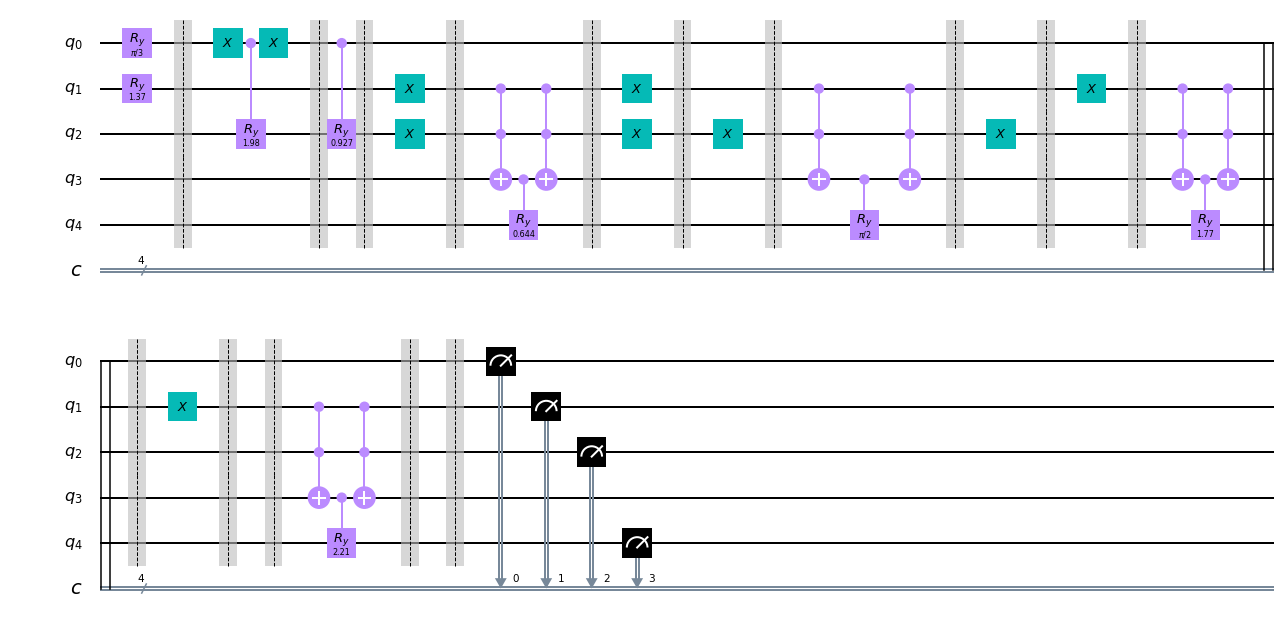

In [11]:
%config InlineBackend.figure_format
circuit.draw(output='mpl')
#circuit.draw()

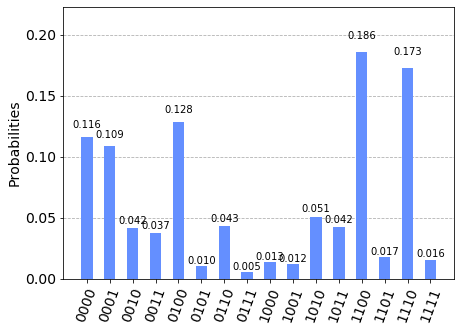

In [12]:
plot_histogram(result.get_counts())

In [13]:
generate_test_circuit().draw()

░                                                                       »
 q_0: ─░───■───────────────────────────────────────────────────────────────────»
       ░   │                                                                   »
 q_1: ─░───■───────────────────────────────────────────────────────────────────»
       ░   │                                                                   »
 q_2: ─░───┼────■──────────────────────────────────────────────────────────────»
       ░   │    │                                                              »
 q_3: ─░───┼────┼────■─────────────────────────────────────────────────────────»
       ░   │    │    │                                                         »
 q_4: ─░───┼────┼────┼────■────────────────────────────────────────────────────»
       ░   │    │    │    │                                                    »
 q_5: ─░───┼────┼────┼────┼────■───────────────────────────────────────────────»
       ░   │    │    │    │    │                                               »
 q_6: ─░───┼────┼────┼────┼────┼────■──────────────────────────────────────────»
       ░   │    │    │    │    │    │                                          »
 q_7: ─░───┼────┼────┼────┼────┼────┼────■──────────────────────────────────■──»
       ░   │    │    │    │    │    │    │                                  │  »
 q_8: ─░───┼────┼────┼────┼────┼────┼────┼────■────────────────────────■────┼──»
       ░   │    │    │    │    │    │    │    │                        │    │  »
 q_9: ─░───┼────┼────┼────┼────┼────┼────┼────┼────■──────────────■────┼────┼──»
       ░ ┌─┴─┐  │    │    │    │    │    │    │    │              │    │    │  »
q_10: ─░─┤ X ├──■────┼────┼────┼────┼────┼────┼────┼──────────────┼────┼────┼──»
       ░ └───┘┌─┴─┐  │    │    │    │    │    │    │              │    │    │  »
q_11: ─░──────┤ X ├──■────┼────┼────┼────┼────┼────┼──────────────┼────┼────┼──»
       ░      └───┘┌─┴─┐  │    │    │    │    │    │              │    │    │  »
q_12: ─░───────────┤ X ├──■────┼────┼────┼────┼────┼──────────────┼────┼────┼──»
       ░           └───┘┌─┴─┐  │    │    │    │    │              │    │    │  »
q_13: ─░────────────────┤ X ├──■────┼────┼────┼────┼──────────────┼────┼────┼──»
       ░                └───┘┌─┴─┐  │    │    │    │              │    │    │  »
q_14: ─░─────────────────────┤ X ├──■────┼────┼────┼──────────────┼────┼────┼──»
       ░                     └───┘┌─┴─┐  │    │    │              │    │    │  »
q_15: ─░──────────────────────────┤ X ├──■────┼────┼──────────────┼────┼────■──»
       ░                          └───┘┌─┴─┐  │    │              │    │  ┌─┴─┐»
q_16: ─░───────────────────────────────┤ X ├──■────┼──────────────┼────■──┤ X ├»
       ░                               └───┘┌─┴─┐  │              │  ┌─┴─┐└───┘»
q_17: ─░────────────────────────────────────┤ X ├──■──────────────■──┤ X ├─────»
       ░                                    └───┘┌─┴─┐          ┌─┴─┐└───┘     »
q_18: ─░─────────────────────────────────────────┤ X ├────■─────┤ X ├──────────»
       ░                                         └───┘┌───┴────┐└───┘          »
q_19: ─░──────────────────────────────────────────────┤ RY(pi) ├───────────────»
       ░                                              └────────┘               »
 c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                               »
 c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                               »
 c_2: ═════════════════════════════════════════════════════════════════════════»
                                                                               »
 c_3: ═════════════════════════════════════════════════════════════════════════»
                                                                               »
 c_4: ════════════════════════════════

In [15]:
oil_graph = {'IR': ([], [.75, .25]), # From 2004.14803, Fig 10
         'SM': (['IR'], [.3, .7, .8, .2]), #P(0|!A), P(1|!A), P(0|A), P(1|A)
         'OI': ([], [.6, .4]),
         'SP': (['OI', 'SM'], [.9, .1, .5, .5, .4, .6, .2, .8])
        }

liquidity = {'X1': (['X9'], [.488,.552,.067,.933]),
             'X2': (['X4'], [.76,.24,1,0]),
             'X3': (['X5'], [1,0,.949,.051]),
             'X4': (['X9', 'X1'], [.151,.849,.874,.126,1,0,1,0]),
             'X5': (['X8','X4'],[0,1,0,1,.723,.277,.311,.689]),
             'X6': ([], [.98,.02]),
             'X7': (['X6'],[.988,.012,.429,.571]),
             'X8': (['X7'],[.006,.994,.875,.125]),
             'X9': (['X8'],[0,1,.982,.018]),
             'X10': (['X4','X2','X1'],[.684,.316,0,1,0,1,.474,.526,1,0,0,1,.481,.519,1,0])
        
        }


In [42]:
liq_circuit = create_circuit(liquidity)

{'X6': 0, 'X7': 1, 'X8': 3, 'X9': 4, 'X1': 5, 'X4': 6, 'X5': 8, 'X2': 9, 'X3': 10, 'X10': 11}


In [45]:
result = run_circuit(liq_circuit, "liquidity", shots=1024*8, draw_circuit=False, use_sim=True, use_qcomp=False, use_noise=False)

{'0011011000': 4, '1000100111': 2, '1001100111': 5, '0011010100': 487, '1011010100': 509, '0111010100': 22, '0001011000': 31, '1111000100': 5, '1111010101': 1, '0011010111': 1, '1111001010': 1, '1001100101': 19, '1111010100': 25, '0001001010': 2, '0101010101': 1, '1001101100': 2, '1011000100': 123, '1101100100': 108, '1111001100': 1, '1001000100': 115, '1011011100': 24, '0001011011': 45, '0011011010': 8, '0001001011': 1, '1011001010': 1, '1001100100': 2013, '1001001010': 2, '1111011000': 1, '1011011000': 3, '0011010101': 5, '1001100110': 3, '0001001100': 2, '1000100101': 4, '1000100100': 934, '1011011010': 10, '1011010110': 1, '0101010100': 149, '0001010111': 8, '0101011100': 5, '0101011010': 2, '1101000100': 5, '1000101010': 1, '0001010100': 3003, '0101011000': 2, '1011001000': 2, '1101100110': 1, '0101000100': 9, '1001001100': 1, '0001010101': 25, '0001001000': 2, '0001011001': 1, '0001000110': 1, '0001011101': 1, '0111011100': 1, '1101100101': 1, '0001011100': 96, '1011011011': 10, 

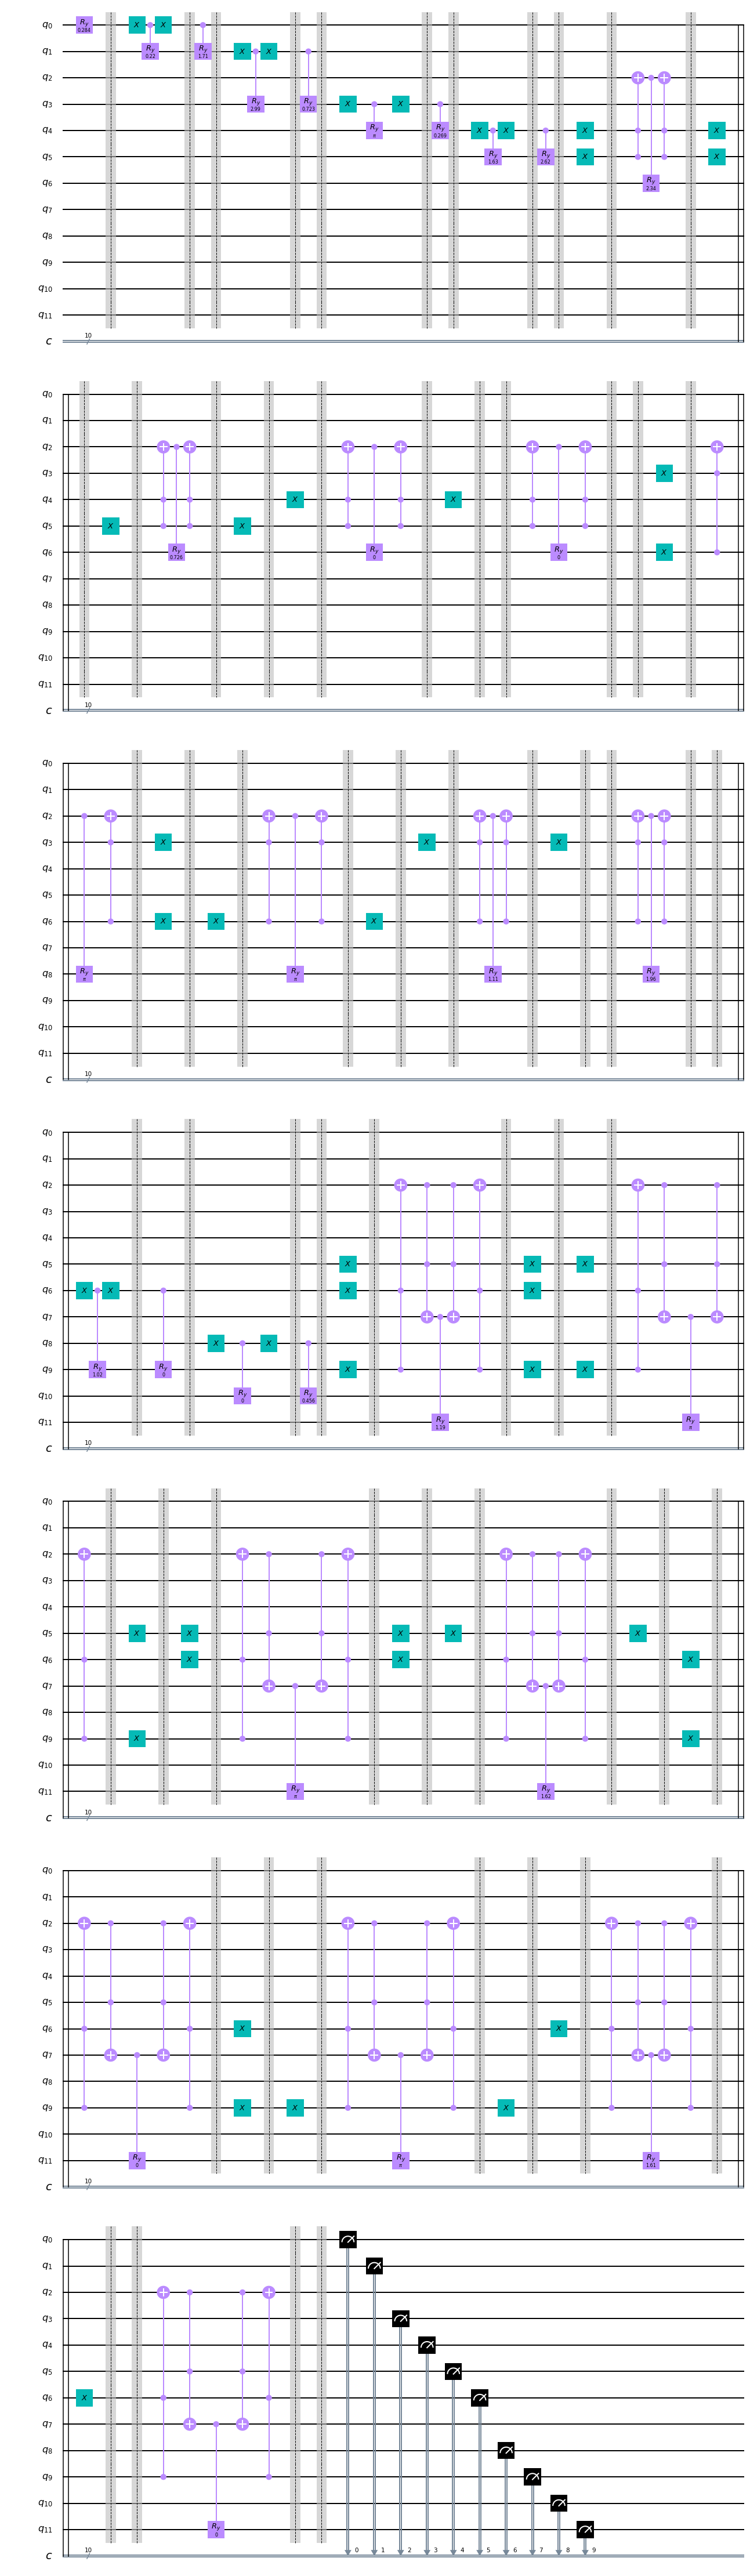

In [46]:
liq_circuit.draw(output='mpl')